In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os 
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_events, plot_compare_evokeds
from mne import combine_evoked

import seaborn as sns
import glob
import pickle
from scipy.stats import norm
from scipy.ndimage import label
from scipy import stats
from scipy import ndimage
import scipy.io
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
epoched = mne.read_epochs('sub-s01_task-faceFO_eeg.fif');



Reading C:\Users\davide_momi\Desktop\Dave\eeg_mne_workshop\sub-s01_task-faceFO_eeg.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
191 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


Applying baseline correction (mode: mean)
Projections have already been applied. Setting proj attribute to True.


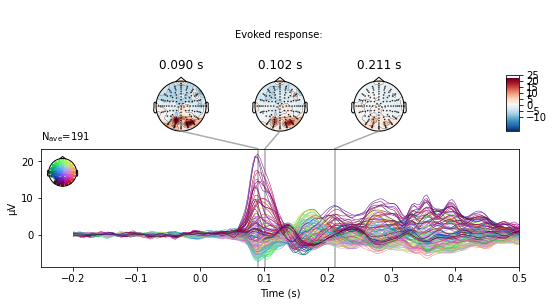

In [3]:
evoked = epoched.average()
evoked.set_eeg_reference('average', projection=True, verbose=False);
evoked.apply_baseline()
# only show -250 to 500 ms
ts_args = dict(xlim=(-0.25, 0.5))

ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=0.05, tmax=0.1)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.2)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.2, tmax=0.25)

times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(times=times, title='Evoked response: ' , ts_args=ts_args);

## Frequency Analysis

We start by exploring the frequency content of our epochs.

Let’s first check out all channel types by averaging across epochs.

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


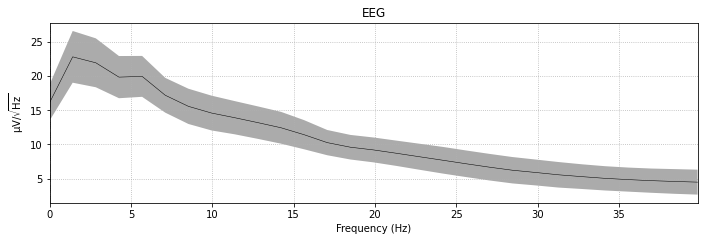

In [4]:
epoched.plot_psd(fmax=40,dB=False, average=True);

Now, let’s take a look at the spatial distributions of the PSD, averaged across epochs and frequency bands.

NOTE: plot_psd_topomap() is a legacy function. New code should use .compute_psd().plot_topomap().
    Using multitaper spectrum estimation with 7 DPSS windows


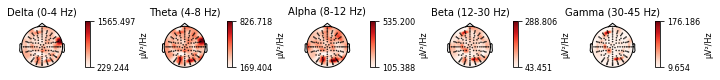

In [5]:
epoched.plot_psd_topomap(normalize=False, dB=False);

Alternatively, you can also create PSDs from Epochs with functions that start with psd_ such as `mne.time_frequency.psd_multitaper()` and `mne.time_frequency.psd_welch()`.

Notably, `mne.time_frequency.psd_welch()` supports the keyword argument average, which specifies how to estimate the PSD based on the individual windowed segments. The default is average='mean', which simply calculates the arithmetic mean across segments. Specifying average='median', in contrast, returns the PSD based on the median of the segments (corrected for bias relative to the mean), which is a more robust measure.

Effective window size : 0.703 (s)


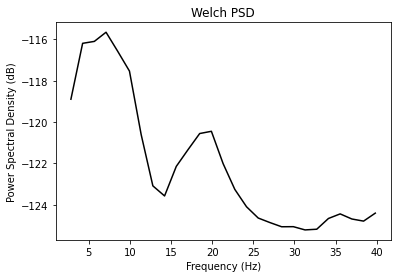

In [6]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=1, n_fft=180)
psds_welch_mean, freqs_mean = mne.time_frequency.psd_welch(epoched, average='mean', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'b1'
ch_idx = epoched.info['ch_names'].index(ch_name)
epo_idx = 2

_, ax = plt.subplots()
ax.plot(freqs_mean, np.mean(psds_welch_mean[:, ch_idx, :], axis=0), color='k',
        ls='-', label='mean of segments')


ax.set(title='Welch PSD',
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
plt.show()

## Stats: Permutation Testing and Cluster Corrections

Import the Time-Frequency data that has been already computed for you

In [7]:
tf = loadmat('groupTFdata.mat')

frex = np.squeeze(tf['frex'])
times2save = np.squeeze(tf['times2save'])
tf = tf['tf']

In [8]:
cond_1 = np.mean(tf[:,0,:,:], axis=0)
cond_2 = np.mean(tf[:,1,:,:], axis=0)

Text(0, 0.5, 'freq')

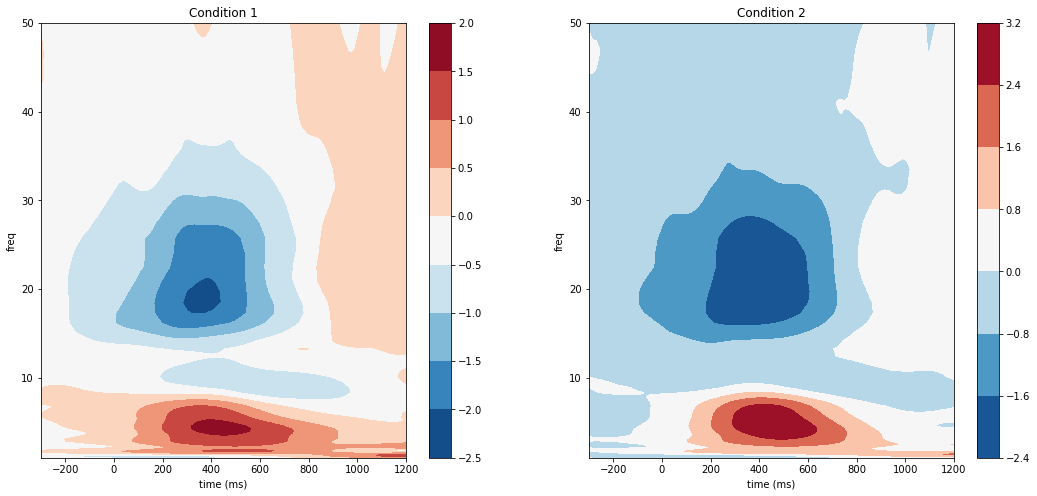

In [9]:
fig,ax=plt.subplots(1,2, figsize=(18, 8))
cp = ax[0].contourf(times2save, frex, cond_1, cmap="RdBu_r")
ax[0].set_title('Condition 1')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('freq')
fig.colorbar(cp, ax=ax[0])

cp = ax[1].contourf(times2save, frex, cond_2, cmap="RdBu_r")
fig.colorbar(cp, ax=ax[1])
ax[1].set_title('Condition 2')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('freq')


stats parameters

In [10]:
time=times2save
nSubs = tf.shape[0]
nPerms=1000
pval    = 0.01 # p-value threshold
sigThresh =norm.ppf(1-pval/2) #note: two-tailed!

Compute true differences

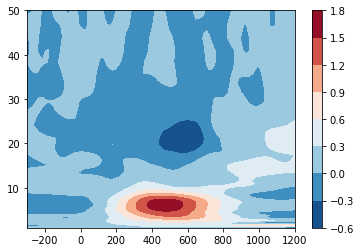

In [11]:
tfdiff = (tf[:,1,:,:]) - (tf[:,0,:,:]);

cp = plt.contourf(times2save, frex, np.mean(tfdiff,axis=0), cmap="RdBu_r")
plt.colorbar()

Let's start permutation

In [12]:
tfFake = np.zeros((nSubs,tf.shape[2],tf.shape[3] )) #initialize
permutedDiffs = np.zeros((nPerms,tf.shape[2],tf.shape[3])); #initialize

for permi in range(nPerms):
    
    #random sequence of +/-1
    fakeconds = np.sign(np.random.randn(nSubs))
    
    for sub in range(nSubs):
        tfFake[sub,:,:] =fakeconds[sub] * tfdiff[sub,:,:]
        
           
    permutedDiffs[permi, :, :] =  np.mean(tfFake,axis=0)
    

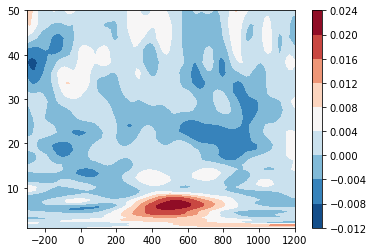

In [13]:
cp = plt.contourf(times2save, frex, np.mean(permutedDiffs,axis=0), cmap="RdBu_r")
plt.colorbar()

In [14]:
clustsizes = np.zeros(nPerms) #initialize cluster sizes from permutation

for permi in range(nPerms):
    #zdiffFake = stats.zscore(permutedDiffs[permi, :, :]) #compute z-score difference
    zdiffFake =  (permutedDiffs[permi, :, :] - np.mean(permutedDiffs)) / np.std(permutedDiffs)
    zdiffFake[np.abs(zdiffFake) <sigThresh] = 0 #threshold

    #cluster area
    lw, num  = ndimage.label(zdiffFake !=0)
    area = ndimage.measurements.sum(zdiffFake !=0, lw, index=np.arange(lw.max() + 1))

    clustsizes[permi]= np.max(area)


clustthresh = np.percentile(clustsizes, 100-pval*100)

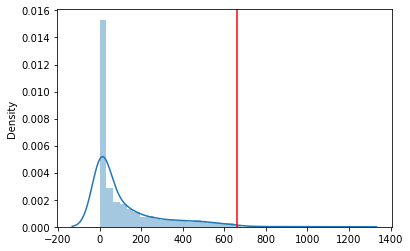

In [15]:
sns.distplot(clustsizes)
plt.axvline(clustthresh, color='red')

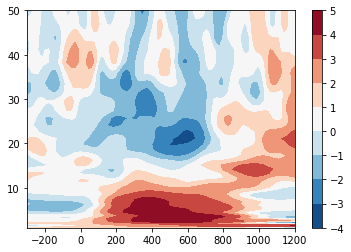

In [16]:
zmap = ((np.mean(tfdiff, axis=0)) - (np.mean(permutedDiffs, axis=0))) / (np.std(permutedDiffs,axis=0))

cp = plt.contourf(times2save, frex, zmap, cmap="RdBu_r")
plt.colorbar()

In [17]:
zmap[np.abs(zmap) <sigThresh] = 0 #threshold z-score difference
    
lw, num  = ndimage.label(zmap !=0)
real_clusters_area = ndimage.measurements.sum(zmap !=0, lw, index=np.arange(lw.max() + 1))
zthresh_clustered = np.zeros((zmap.shape[0], zmap.shape[1]))


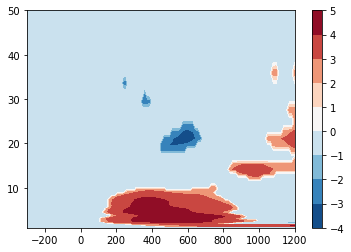

In [18]:
cp = plt.contourf(times2save, frex, zmap, cmap="RdBu_r")
plt.colorbar()


In [19]:
# find cluster sizes
for clst in range(real_clusters_area.shape[0]):
        if real_clusters_area[clst] > clustthresh:
            zthresh_clustered[np.where(lw==np.unique(lw)[clst])] = zmap[np.where(lw==np.unique(lw)[clst])]



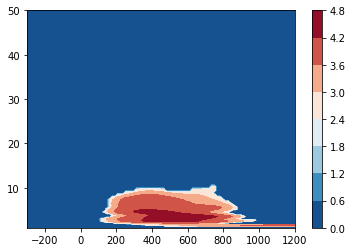

In [20]:
cp = plt.contourf(times2save, frex, zthresh_clustered, cmap="RdBu_r")
plt.colorbar()
